# Tiny object detection

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from PIL import ImageDraw, Image

In [2]:
B = 0
INPUT_CROP_SIZE, FEATURE_MAP_SIZE = EFFICIENT_NET_SIZES[B]
BIG_CROP_SIZE = int(INPUT_CROP_SIZE * 1.2)
os.listdir(DATA_DIR)

['ImageSets', 'Annotations', 'JPEGImages']

In [3]:
with open(DATA_DIR+'/ImageSets/Main/test.txt') as f:
    test_i = f.read().split('\n')[:-1]

test_idxs = [int(t) for t in test_i]

with open(DATA_DIR+'/ImageSets/Main/train.txt') as f:
    train_i = f.read().split('\n')[:-1]

train_idxs = [int(t) for t in train_i]

In [4]:
import albumentations as A
def augment(img_array, anns, nn_crop_size, feature_map_size):
    """Get big crop with bboxes and augment
    return crop for NN and labels """
    big_crop_size, other_size, _ = img_array.shape
    assert big_crop_size == other_size
    bboxes = [ann_to_numpy(a) for a in anns]
    category_ids = [1]*len(bboxes)
    
    bbox_params = A.BboxParams(
        format='pascal_voc',
        label_fields=['category_ids'])
    
    transform = A.Compose([
        A.RandomCrop(nn_crop_size, nn_crop_size),
        A.HorizontalFlip(),
        A.RandomBrightnessContrast()
    ], 
        bbox_params=bbox_params
    )
    
    aug = transform(
        image=img_array, 
        bboxes=bboxes, 
        category_ids=category_ids
    )
    # print(aug['bboxes'])
    aug_y = get_feature_map(
        aug['bboxes'],
        nn_crop_size, 
        feature_map_size)
    
    return aug['image'], aug_y

In [5]:
_, x, _, anns  = crop_sample(1, BIG_CROP_SIZE, FEATURE_MAP_SIZE)[0]

In [6]:
aug_x, aug_y = augment(x, anns, INPUT_CROP_SIZE, FEATURE_MAP_SIZE)


In [7]:
def test_gen():
    for i in test_idxs:
        out = crop_sample(i, INPUT_CROP_SIZE, FEATURE_MAP_SIZE)
        for o in out:
            _, x, y, _ = o
            yield x, y
        
def train_gen():
    for i in train_idxs:
        out = crop_sample(i, BIG_CROP_SIZE, FEATURE_MAP_SIZE)
        for o in out:
            _, x, _, anns = o
            aug_x, aug_y = augment(x, anns, INPUT_CROP_SIZE, FEATURE_MAP_SIZE)
            yield aug_x, aug_y

In [8]:
BATCH_SIZE = 8

test_dataset = tf.data.Dataset.from_generator(
     test_gen,
     output_signature=(
         tf.TensorSpec(shape=(INPUT_CROP_SIZE, INPUT_CROP_SIZE, 3), dtype=tf.uint8),
         tf.TensorSpec(shape=(FEATURE_MAP_SIZE, FEATURE_MAP_SIZE), dtype=tf.uint8)
     )
).shuffle(BATCH_SIZE*4).batch(BATCH_SIZE).prefetch(BATCH_SIZE)

train_dataset = tf.data.Dataset.from_generator(
     train_gen,
     output_signature=(
         tf.TensorSpec(shape=(INPUT_CROP_SIZE, INPUT_CROP_SIZE, 3), dtype=tf.uint8),
         tf.TensorSpec(shape=(FEATURE_MAP_SIZE, FEATURE_MAP_SIZE), dtype=tf.uint8)
     )
).shuffle(BATCH_SIZE*4).batch(BATCH_SIZE).prefetch(BATCH_SIZE)

### Test crop_sample()

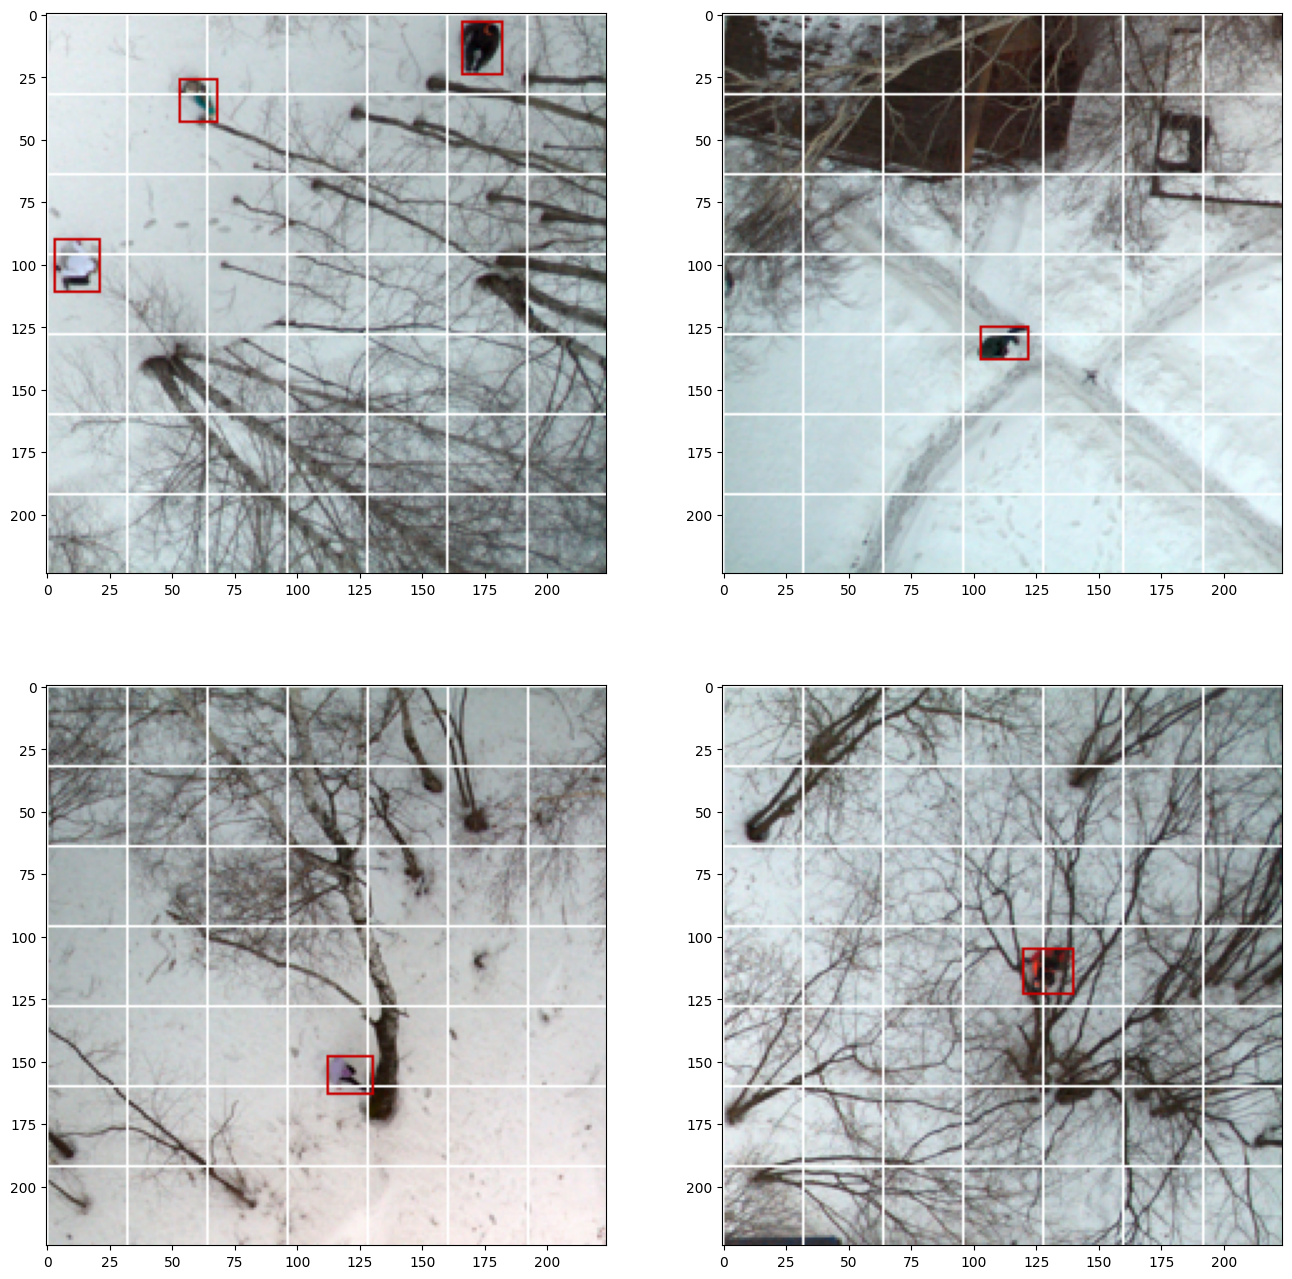

In [9]:
out = crop_sample(0, CROP_SIZE=INPUT_CROP_SIZE, FEATURE_MAP_SIZE=FEATURE_MAP_SIZE)
plt.figure(figsize=(16,16))

for i in range(4):
    crop_idx, img_arr, y, anns = out[i]
    img = tf.keras.utils.array_to_img(img_arr)
    draw = ImageDraw.Draw(img)
    w,h = img.size
    ff = 32
    for f in range(FEATURE_MAP_SIZE):
        draw.line((ff*f, 0, ff*f, h))
        draw.line((0, ff*f, w, ff*f))
        
    for a in anns:
        bb = a.bbox
        draw.rectangle(bb, outline=(200,0,0))

    plt.subplot(2,2,i+1)
    plt.imshow(img)
plt.show()

### Test dataset

In [26]:
it = iter(test_dataset)

In [52]:
sample = next(it)
sample[0].shape, sample[1].shape

(TensorShape([8, 224, 224, 3]), TensorShape([8, 7, 7]))

In [49]:
np.array(np.where(y==1))

array([], shape=(2, 0), dtype=int64)

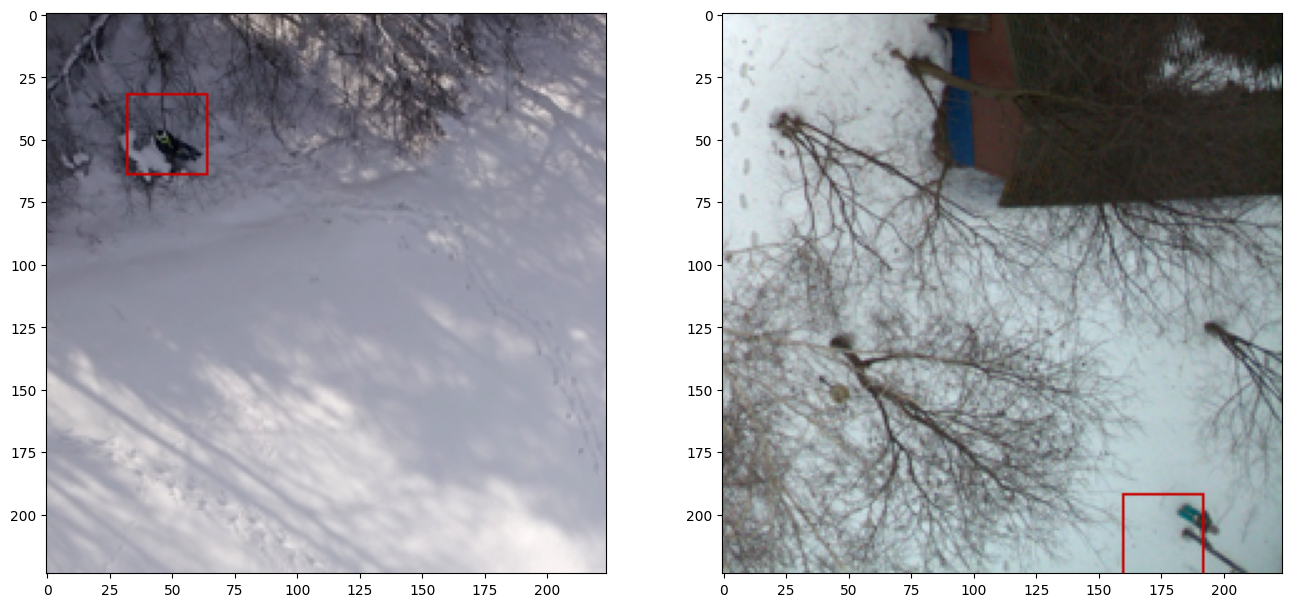

In [53]:
plt.figure(figsize=(16,16))
for i in range(4):
    img_arr = sample[0][i].numpy()
    y = sample[1][i].numpy()
    try:
        img = tf.keras.utils.array_to_img(img_arr)
        xy = np.array(np.where(y==1)).ravel()[::-1]
        bb = np.array([xy, xy+1]).ravel() * 32

        draw = ImageDraw.Draw(img)
        draw.rectangle(bb.tolist(), outline=(200,0,0))
        y_img = Image.fromarray(y*255)
        y_img=y_img.resize((INPUT_CROP_SIZE, INPUT_CROP_SIZE))
    except TypeError:
        continue
        
    plt.subplot(2,2,i+1)
    plt.imshow(img)
plt.show()    

### Train dataset

In [ ]:
it = iter(train_dataset)

In [ ]:
sample = next(it)
sample[0].shape, sample[1].shape
plt.figure(figsize=(16,16))
for i in range(4):
    img_arr = sample[0][i].numpy()
    y = sample[1][i].numpy()

    img = tf.keras.utils.array_to_img(img_arr)

    y_img = Image.fromarray(y*255)
    y_img=y_img.resize((INPUT_CROP_SIZE, INPUT_CROP_SIZE))

    plt.subplot(2,2,i+1)
    plt.imshow(Image.blend(y_img.convert('RGBA'), img.convert('RGBA'), alpha=0.4))
plt.show()   

### Backbone loading

In [10]:
model_name = f'B{B}'
backbone = tf.keras.models.load_model(f'backbones/{model_name}')

backbone.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_1 (Rescaling)        (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_1 (Normalization  (None, None, None,   7          ['rescaling_1[0][0]']            
 )                              3)                                                   

In [ ]:
x, y_true = next(it)
# x = tf.expand_dims(x, 0)
y_pred = backbone(x)
y_pred.shape

### Pedestrian detection model

In [ ]:
class PeDet(tf.keras.Model):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.backbone.trainable = False
        self.dense1 = tf.keras.layers.Dense(256, activation='relu')
        self.dense3 = tf.keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, x):
        out = self.backbone(x)
        out = self.dense1(out)
        out = self.dense3(out)
        return out

In [ ]:
pedet = PeDet(backbone)

In [ ]:
THRESH = 0.3
LOG_DIR = f'./logs/GPU{B}'

precision = tf.keras.metrics.Precision(thresholds=THRESH)
recall = tf.keras.metrics.Recall(thresholds=THRESH)
auc = tf.keras.metrics.AUC()

In [ ]:
! rm -rf {LOG_DIR}

In [ ]:
tbc = tf.keras.callbacks.TensorBoard(
    log_dir=LOG_DIR,
    update_freq='epoch'
)

In [ ]:
lr_scheduler = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=64000
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)
pedet.compile(optimizer=optimizer, 
              loss=focal_loss, 
              metrics=[precision, recall, auc])

In [ ]:
hist = pedet.fit(train_dataset, 
                 validation_data=test_dataset, 
                 epochs=64,
                callbacks=[tbc]
        )

In [ ]:
pedet.save(f'snapshots/{model_name}')